# Example modeling process

### Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model specific imports
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import (get_training_observations, 
                     get_training_labels, 
                     get_protein_proportions,
                     drop_empty_columns)

### Load training data and labels

In [2]:
x_train_raw_counts = get_training_observations()
x_train = get_protein_proportions(x_train_raw_counts)
print(f"There are {x_train.shape[1]} features")
y_train = get_training_labels()

Getting all training observations from 'metagenome_classification.db'...
There are 16306 features
Getting all training labels from 'metagenome_classification.db'...


In [3]:
x_train.head(10)

index,PF00001.19,PF00002.22,PF00003.20,PF00004.27,PF00005.25,PF00006.23,PF00007.20,PF00008.25,PF00009.25,PF00010.24,...,PF17216.1,PF17217.1,PF17218.1,PF17219.1,PF17220.1,PF17221.1,PF17222.1,PF17223.1,PF17224.1,PF17225.1
0,0.000004,6.092434e-07,0.000000,0.001285,0.021986,0.000809,0.0,0.000010,0.001546,6.092434e-07,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000010,0.000000e+00,0.000003,0.001523,0.015320,0.001126,0.0,0.000024,0.002005,3.392429e-06,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.000000e+00,0.000000,0.001595,0.011640,0.001008,0.0,0.000000,0.001650,0.000000e+00,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.000000e+00,0.000010,0.002188,0.018117,0.001597,0.0,0.000000,0.002543,0.000000e+00,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000002,0.000000e+00,0.000000,0.001786,0.014518,0.000924,0.0,0.000000,0.001915,3.916983e-06,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5,0.000012,1.197289e-05,0.000000,0.002706,0.008824,0.001257,0.0,0.000000,0.002155,0.000000e+00,...,0.000012,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
6,0.000000,0.000000e+00,0.000000,0.002233,0.013982,0.001488,0.0,0.000005,0.002459,5.383928e-06,...,0.000005,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7,0.000000,0.000000e+00,0.000000,0.001661,0.018014,0.000828,0.0,0.000000,0.001876,0.000000e+00,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
8,0.005429,9.319447e-05,0.000047,0.001631,0.012302,0.000815,0.0,0.000396,0.001375,3.494793e-04,...,0.000000,0.000047,0.0,0.0,0.0,0.000023,0.0,0.0,0.0,0.0
9,0.000008,0.000000e+00,0.000000,0.002739,0.016584,0.001230,0.0,0.000000,0.002286,0.000000e+00,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [4]:
y_train.head()

index,EMPO_1,EMPO_2,EMPO_3
0,Host-associated,Plant,Plant rhizosphere
1,Free-living,Non-saline,Soil (non-saline)
2,Free-living,Saline,Water (saline)
3,Free-living,Non-saline,Water (non-saline)
4,Free-living,Non-saline,Soil (non-saline)


### Data manipulation
Validation splits, dimensionality reduction, etc

In [5]:
# convert string labels to numeric
labels3 = [
    'Aerosol (non-saline)',
    'Animal corpus',
    'Animal proximal gut',
    'Hypersaline (saline)',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Sediment (saline)',
    'Soil (non-saline)',
    'Subsurface (non-saline)',
    'Surface (non-saline)',
    'Surface (saline)',
    'Water (non-saline)',
    'Water (saline)'
]
labels3_map = {}
for i in range(0,len(labels3)):
    label = labels3[i]
    labels3_map[label] = i

y_train['EMPO_3_int'] = y_train['EMPO_3'].map(labels3_map)

In [6]:
# Split into train/validation if not CV
X_tr, X_val, Y_tr, Y_val = train_test_split(x_train, y_train, test_size=0.2) #, random_state=1)

# Dimensionality reduction?
#svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
#svd.fit(X_tr)
#new_x_train = svd.transform(X_tr)
#new_x_val = svd.transform(X_val)


### Model training

Training...
Epoch 1/20


2022-07-30 10:49:44.425869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


15/15 [==============================] - 4s 207ms/step - loss: 2.0714 - accuracy: 0.3293 - val_loss: 1.7763 - val_accuracy: 0.3000
Epoch 2/20
15/15 [==============================] - 3s 223ms/step - loss: 1.6185 - accuracy: 0.5150 - val_loss: 1.5305 - val_accuracy: 0.5800
Epoch 3/20
15/15 [==============================] - 3s 191ms/step - loss: 1.3340 - accuracy: 0.6574 - val_loss: 1.3134 - val_accuracy: 0.6800
Epoch 4/20
15/15 [==============================] - 2s 149ms/step - loss: 1.1532 - accuracy: 0.7164 - val_loss: 1.2474 - val_accuracy: 0.6600
Epoch 5/20
15/15 [==============================] - 2s 142ms/step - loss: 1.0290 - accuracy: 0.7575 - val_loss: 1.1469 - val_accuracy: 0.6600
Epoch 6/20
15/15 [==============================] - 3s 189ms/step - loss: 0.9279 - accuracy: 0.7720 - val_loss: 1.0540 - val_accuracy: 0.7000
Epoch 7/20
15/15 [==============================] - 4s 226ms/step - loss: 0.8872 - accuracy: 0.7764 - val_loss: 1.1659 - val_accuracy: 0.7100
Epoch 8/20
15/15 

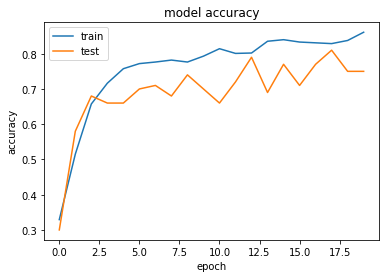

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 974)               15883018  
                                                                 
 dropout (Dropout)           (None, 974)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                14625     
                                                                 
Total params: 15,897,643
Trainable params: 15,897,643
Non-trainable params: 0
_________________________________________________________________


In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

def build_model(n_classes,
  hidden_layer_sizes=[],
  activation='relu',
  final_layer_activation='softmax',
  dropout=0.0,
  kernel_regularizer=1e-5,
  bias_regularizer=1e-5,
  activity_regularizer=1e-5,
  optimizer='Adam',
  learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)
  model = keras.Sequential()
  model.add(keras.layers.Flatten())

  for hidden_layer_size in hidden_layer_sizes:
        if hidden_layer_size > n_classes:
            model.add(keras.layers.Dense(
                hidden_layer_size,
                activation=activation,
                kernel_regularizer=keras.regularizers.L2(kernel_regularizer),
                bias_regularizer=keras.regularizers.L2(bias_regularizer),
                activity_regularizer=keras.regularizers.L2(activity_regularizer)
            ))
            if dropout > 0:
                model.add(keras.layers.Dropout(dropout))
  model.add(keras.layers.Dense(
        n_classes,
        activation=final_layer_activation,
        kernel_regularizer=keras.regularizers.L2(kernel_regularizer),
        bias_regularizer=keras.regularizers.L2(bias_regularizer),
        activity_regularizer=keras.regularizers.L2(activity_regularizer)
  ))
  opt = None
  if optimizer == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  else:
    raise f"Unsupported optimizer, {optimizer}"
  model.compile(loss='sparse_categorical_crossentropy', 
    optimizer=opt, metrics=['accuracy'])    
  return model

def train_model(X_train, Y_train, num_classes,
  hidden_layer_sizes=[],
  kernel_regularizer=0,
  bias_regularizer=0,
  activity_regularizer=0,
  activation='tanh',
  final_layer_activation='softmax',
  dropout=0.2,
  optimizer='Adam',
  learning_rate=0.01,
  batch_size=64,
  num_epochs=5):

  # Build the model.
  model = build_model(
        num_classes,
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        final_layer_activation=final_layer_activation,
        dropout=dropout,
        kernel_regularizer=1e-5,
        bias_regularizer=1e-5,
        activity_regularizer=1e-5,
        optimizer=optimizer,
        learning_rate=learning_rate)

  # Train the model.
  print('Training...')
  history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  model.summary()
  return model

# model with 1 hidden layers
nn1a = train_model(X_tr, Y_tr['EMPO_3_int'], 15,
    hidden_layer_sizes=[974],
    kernel_regularizer=1.9e-08,
    bias_regularizer=4.8e-05,
    activity_regularizer=1.1e-06,
    dropout=0.058,
    optimizer='Adam',
    learning_rate=0.009,
    batch_size=64,
    num_epochs=20)


Training...
Epoch 1/20
15/15 [==============================] - 2s 125ms/step - loss: 2.0836 - accuracy: 0.3482 - val_loss: 1.7687 - val_accuracy: 0.2900
Epoch 2/20
15/15 [==============================] - 2s 105ms/step - loss: 1.6619 - accuracy: 0.4705 - val_loss: 1.5903 - val_accuracy: 0.5800
Epoch 3/20
15/15 [==============================] - 2s 109ms/step - loss: 1.3852 - accuracy: 0.6596 - val_loss: 1.3663 - val_accuracy: 0.6700
Epoch 4/20
15/15 [==============================] - 2s 105ms/step - loss: 1.2049 - accuracy: 0.7063 - val_loss: 1.2536 - val_accuracy: 0.6600
Epoch 5/20
15/15 [==============================] - 2s 110ms/step - loss: 1.0686 - accuracy: 0.7642 - val_loss: 1.1785 - val_accuracy: 0.6700
Epoch 6/20
15/15 [==============================] - 2s 112ms/step - loss: 0.9635 - accuracy: 0.7709 - val_loss: 1.0867 - val_accuracy: 0.6900
Epoch 7/20
15/15 [==============================] - 2s 116ms/step - loss: 0.9138 - accuracy: 0.7664 - val_loss: 1.0942 - val_accuracy: 0

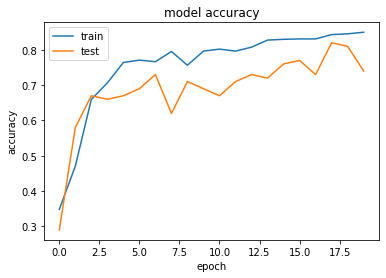

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 710)               11577970  
                                                                 
 dropout (Dropout)           (None, 710)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                10665     
                                                                 
Total params: 11,588,635
Trainable params: 11,588,635
Non-trainable params: 0
_________________________________________________________________


In [8]:
# hyperparameters from second run of Optuna (expect very similar results to above despite different params)
nn1b = train_model(X_tr, Y_tr['EMPO_3_int'], 15,
    hidden_layer_sizes=[710],
    kernel_regularizer=2.0e-07,
    bias_regularizer=1.4e-05,
    activity_regularizer=5.7e-05,
    dropout=0.021,
    optimizer='Adam',
    learning_rate=0.009,
    batch_size=64,
    num_epochs=20)

Training...
Epoch 1/20
15/15 [==============================] - 2s 55ms/step - loss: 2.1177 - accuracy: 0.2659 - val_loss: 1.7334 - val_accuracy: 0.3800
Epoch 2/20
15/15 [==============================] - 1s 42ms/step - loss: 1.5293 - accuracy: 0.4761 - val_loss: 1.3483 - val_accuracy: 0.5600
Epoch 3/20
15/15 [==============================] - 1s 40ms/step - loss: 1.1716 - accuracy: 0.5996 - val_loss: 1.1855 - val_accuracy: 0.6100
Epoch 4/20
15/15 [==============================] - 1s 42ms/step - loss: 0.9079 - accuracy: 0.7241 - val_loss: 0.9932 - val_accuracy: 0.6900
Epoch 5/20
15/15 [==============================] - 1s 42ms/step - loss: 0.7816 - accuracy: 0.7753 - val_loss: 1.0525 - val_accuracy: 0.7000
Epoch 6/20
15/15 [==============================] - 1s 42ms/step - loss: 0.6707 - accuracy: 0.8020 - val_loss: 0.9388 - val_accuracy: 0.7200
Epoch 7/20
15/15 [==============================] - 1s 43ms/step - loss: 0.6098 - accuracy: 0.8420 - val_loss: 0.8198 - val_accuracy: 0.7600
E

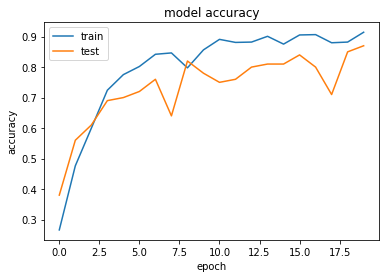

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 231)               3766917   
                                                                 
 dropout (Dropout)           (None, 231)               0         
                                                                 
 dense_1 (Dense)             (None, 303)               70296     
                                                                 
 dropout_1 (Dropout)         (None, 303)               0         
                                                                 
 dense_2 (Dense)             (None, 15)                4560      
                                                                 
Total params: 3,841,773
Trainable params: 3,841,773
Non-

In [9]:
# model with 2 hidden layers
nn2a = train_model(X_tr, Y_tr['EMPO_3_int'], 15,
    hidden_layer_sizes=[231, 303],
    kernel_regularizer=4.5e-06,
    bias_regularizer=2.3e-05,
    activity_regularizer=5.4e-05,
    dropout=0.067,
    optimizer='Adam',
    learning_rate=0.0073,
    batch_size=64,
    num_epochs=20)

Training...
Epoch 1/20
15/15 [==============================] - 2s 84ms/step - loss: 2.0214 - accuracy: 0.2970 - val_loss: 1.4729 - val_accuracy: 0.5400
Epoch 2/20
15/15 [==============================] - 1s 71ms/step - loss: 1.2966 - accuracy: 0.5584 - val_loss: 1.2586 - val_accuracy: 0.5700
Epoch 3/20
15/15 [==============================] - 1s 69ms/step - loss: 0.8972 - accuracy: 0.7308 - val_loss: 0.9448 - val_accuracy: 0.6600
Epoch 4/20
15/15 [==============================] - 1s 67ms/step - loss: 0.7331 - accuracy: 0.7976 - val_loss: 0.7896 - val_accuracy: 0.7400
Epoch 5/20
15/15 [==============================] - 1s 67ms/step - loss: 0.6999 - accuracy: 0.7976 - val_loss: 0.9540 - val_accuracy: 0.7600
Epoch 6/20
15/15 [==============================] - 1s 70ms/step - loss: 0.6190 - accuracy: 0.8343 - val_loss: 0.7779 - val_accuracy: 0.7900
Epoch 7/20
15/15 [==============================] - 1s 67ms/step - loss: 0.5878 - accuracy: 0.8465 - val_loss: 0.7933 - val_accuracy: 0.8300
E

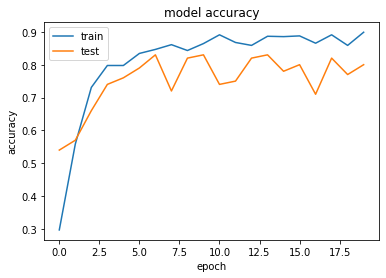

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 380)               6196660   
                                                                 
 dropout (Dropout)           (None, 380)               0         
                                                                 
 dense_1 (Dense)             (None, 543)               206883    
                                                                 
 dropout_1 (Dropout)         (None, 543)               0         
                                                                 
 dense_2 (Dense)             (None, 15)                8160      
                                                                 
Total params: 6,411,703
Trainable params: 6,411,703
Non-

In [10]:
# parameters from second run of Optuna
nn2b = train_model(X_tr, Y_tr['EMPO_3_int'], 15,
    hidden_layer_sizes=[380, 543],
    kernel_regularizer=6.0e-05,
    bias_regularizer=1.6e-05,
    activity_regularizer=1.9e-05,
    dropout=0.085,
    optimizer='Adam',
    learning_rate=0.009,
    batch_size=64,
    num_epochs=20)

Training...
Epoch 1/20
15/15 [==============================] - 5s 207ms/step - loss: 2.1933 - accuracy: 0.2503 - val_loss: 1.9104 - val_accuracy: 0.2700
Epoch 2/20
15/15 [==============================] - 3s 170ms/step - loss: 1.7632 - accuracy: 0.3749 - val_loss: 1.4665 - val_accuracy: 0.4200
Epoch 3/20
15/15 [==============================] - 3s 195ms/step - loss: 1.2827 - accuracy: 0.5328 - val_loss: 1.2421 - val_accuracy: 0.5600
Epoch 4/20
15/15 [==============================] - 3s 172ms/step - loss: 0.9697 - accuracy: 0.6997 - val_loss: 1.0386 - val_accuracy: 0.6900
Epoch 5/20
15/15 [==============================] - 3s 186ms/step - loss: 0.7707 - accuracy: 0.7764 - val_loss: 1.1726 - val_accuracy: 0.5800
Epoch 6/20
15/15 [==============================] - 3s 199ms/step - loss: 0.6831 - accuracy: 0.7887 - val_loss: 0.9931 - val_accuracy: 0.6900
Epoch 7/20
15/15 [==============================] - 2s 163ms/step - loss: 0.5832 - accuracy: 0.8365 - val_loss: 0.7543 - val_accuracy: 0

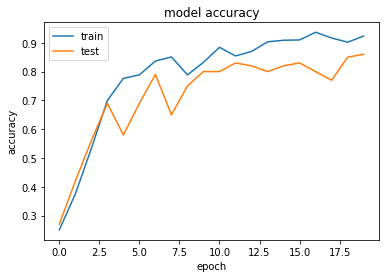

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 1003)              16355921  
                                                                 
 dropout (Dropout)           (None, 1003)              0         
                                                                 
 dense_1 (Dense)             (None, 935)               938740    
                                                                 
 dropout_1 (Dropout)         (None, 935)               0         
                                                                 
 dense_2 (Dense)             (None, 298)               278928    
                                                                 
 dropout_2 (Dropout)         (None, 298)               0

In [11]:
# model with 3 hidden layers
nn3a = train_model(X_tr, Y_tr['EMPO_3_int'], 15,
    hidden_layer_sizes=[1003, 935, 298],
    kernel_regularizer=5.0e-06,
    bias_regularizer=2.0e-05,
    activity_regularizer=10.0e-05,
    dropout=0.025,
    optimizer='Adam',
    learning_rate=0.0015,
    batch_size=64,
    num_epochs=20)

Training...
Epoch 1/20
15/15 [==============================] - 3s 99ms/step - loss: 2.2034 - accuracy: 0.2347 - val_loss: 1.9134 - val_accuracy: 0.2700
Epoch 2/20
15/15 [==============================] - 1s 68ms/step - loss: 1.9113 - accuracy: 0.2836 - val_loss: 1.7019 - val_accuracy: 0.3400
Epoch 3/20
15/15 [==============================] - 1s 72ms/step - loss: 1.4065 - accuracy: 0.5228 - val_loss: 1.2401 - val_accuracy: 0.5700
Epoch 4/20
15/15 [==============================] - 1s 76ms/step - loss: 1.0046 - accuracy: 0.7197 - val_loss: 1.0552 - val_accuracy: 0.7100
Epoch 5/20
15/15 [==============================] - 1s 64ms/step - loss: 0.7774 - accuracy: 0.7653 - val_loss: 1.0588 - val_accuracy: 0.6900
Epoch 6/20
15/15 [==============================] - 1s 80ms/step - loss: 0.6457 - accuracy: 0.8042 - val_loss: 0.9301 - val_accuracy: 0.7300
Epoch 7/20
15/15 [==============================] - 1s 67ms/step - loss: 0.5600 - accuracy: 0.8487 - val_loss: 0.8192 - val_accuracy: 0.7800
E

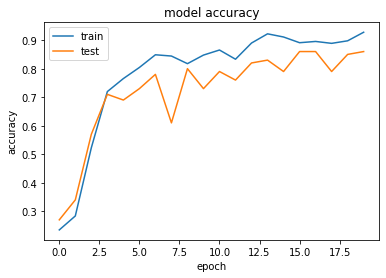

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 176)               2870032   
                                                                 
 dropout (Dropout)           (None, 176)               0         
                                                                 
 dense_1 (Dense)             (None, 714)               126378    
                                                                 
 dropout_1 (Dropout)         (None, 714)               0         
                                                                 
 dense_2 (Dense)             (None, 643)               459745    
                                                                 
 dropout_2 (Dropout)         (None, 643)               0

In [12]:
# 3-layer with second set of parameters from Optuna
nn3b = train_model(X_tr, Y_tr['EMPO_3_int'], 15,
    hidden_layer_sizes=[176, 714, 643],
    kernel_regularizer=2.3e-06,
    bias_regularizer=5.5e-05,
    activity_regularizer=8.2e-05,
    dropout=0.011,
    optimizer='Adam',
    learning_rate=0.0021,
    batch_size=64,
    num_epochs=20)

### Model evaluation

In [14]:
# Scoring model
nn1a_accuracy = nn1a.evaluate(x=X_val, y=Y_val['EMPO_3_int'], verbose=0, return_dict=True)['accuracy']
print(f"Accuracy of 1-layer NN #1 on EMPO 3: {nn1a_accuracy}")
nn1b_accuracy = nn1b.evaluate(x=X_val, y=Y_val['EMPO_3_int'], verbose=0, return_dict=True)['accuracy']
print(f"Accuracy of 1-layer NN #2 on EMPO 3: {nn1b_accuracy}")
nn2a_accuracy = nn2a.evaluate(x=X_val, y=Y_val['EMPO_3_int'], verbose=0, return_dict=True)['accuracy']
print(f"Accuracy of 2-layer NN #1 on EMPO 3: {nn2a_accuracy}")
nn2b_accuracy = nn2b.evaluate(x=X_val, y=Y_val['EMPO_3_int'], verbose=0, return_dict=True)['accuracy']
print(f"Accuracy of 2-layer NN #2 on EMPO 3: {nn2b_accuracy}")
nn3a_accuracy = nn3a.evaluate(x=X_val, y=Y_val['EMPO_3_int'], verbose=0, return_dict=True)['accuracy']
print(f"Accuracy of 3-layer NN #1 on EMPO 3: {nn2a_accuracy}")
nn3b_accuracy = nn3b.evaluate(x=X_val, y=Y_val['EMPO_3_int'], verbose=0, return_dict=True)['accuracy']
print(f"Accuracy of 3-layer NN #2 on EMPO 3: {nn2b_accuracy}")

Accuracy of 1-layer NN #1 on EMPO 3: 0.8080000281333923
Accuracy of 1-layer NN #2 on EMPO 3: 0.8119999766349792
Accuracy of 2-layer NN #1 on EMPO 3: 0.8640000224113464
Accuracy of 2-layer NN #2 on EMPO 3: 0.8519999980926514
Accuracy of 3-layer NN #1 on EMPO 3: 0.8640000224113464
Accuracy of 3-layer NN #2 on EMPO 3: 0.8519999980926514


### Retrain best model
After experimenting with models, retrain your favorite model using entire training set (including validation) before saving

Training...
Epoch 1/15
18/18 [==============================] - 2s 57ms/step - loss: 2.0787 - accuracy: 0.2642 - val_loss: 1.5568 - val_accuracy: 0.5360
Epoch 2/15
18/18 [==============================] - 1s 47ms/step - loss: 1.3194 - accuracy: 0.5525 - val_loss: 1.1155 - val_accuracy: 0.6960
Epoch 3/15
18/18 [==============================] - 1s 50ms/step - loss: 0.9888 - accuracy: 0.7215 - val_loss: 0.8646 - val_accuracy: 0.7680
Epoch 4/15
18/18 [==============================] - 1s 61ms/step - loss: 0.7865 - accuracy: 0.7794 - val_loss: 0.9971 - val_accuracy: 0.7680
Epoch 5/15
18/18 [==============================] - 1s 61ms/step - loss: 0.7240 - accuracy: 0.7989 - val_loss: 0.7803 - val_accuracy: 0.8080
Epoch 6/15
18/18 [==============================] - 1s 49ms/step - loss: 0.6403 - accuracy: 0.8345 - val_loss: 0.6981 - val_accuracy: 0.8160
Epoch 7/15
18/18 [==============================] - 1s 57ms/step - loss: 0.5917 - accuracy: 0.8336 - val_loss: 0.6712 - val_accuracy: 0.8320
E

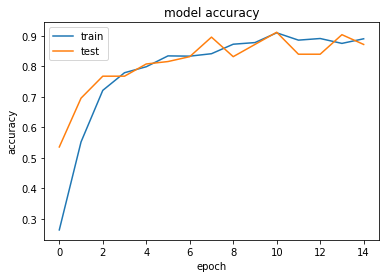

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 231)               3766917   
                                                                 
 dropout (Dropout)           (None, 231)               0         
                                                                 
 dense_1 (Dense)             (None, 303)               70296     
                                                                 
 dropout_1 (Dropout)         (None, 303)               0         
                                                                 
 dense_2 (Dense)             (None, 15)                4560      
                                                                 
Total params: 3,841,773
Trainable params: 3,841,773
Non-

In [15]:
import time

start_time = time.time()

final_nn = train_model(x_train, y_train['EMPO_3_int'], 15,
    hidden_layer_sizes=[231, 303],
    kernel_regularizer=4.5e-06,
    bias_regularizer=2.3e-05,
    activity_regularizer=5.4e-05,
    dropout=0.067,
    optimizer='Adam',
    learning_rate=0.0073,
    batch_size=64,
    num_epochs=15)

end_time = time.time()
wallclock = int(end_time - start_time)
print(f"Wallclock = {wallclock} sec")

In [16]:
final_nn_accuracy = final_nn.evaluate(x=X_val, y=Y_val['EMPO_3_int'], verbose=0, return_dict=True)['accuracy']
print(f"Accuracy of final 2-layer NN on EMPO 3: {final_nn_accuracy}")

Accuracy of final 2-layer NN on EMPO 3: 0.9120000004768372


### Save fitted model

In [17]:
# Save best model as joblib or pkl file to 'model_joblibs' folder
from joblib import dump

dump(final_nn, '../model_joblibs/neural_network_EMPO3.joblib')

INFO:tensorflow:Assets written to: ram://b9556c23-397a-426c-9b83-67374f728230/assets


['../model_joblibs/neural_network_EMPO3.joblib']